# Computational Methods in Simulation (CMIS) Week 2
This notebook is intended to help students make their hand-in in this week of CMIS.


Hand-ins must be submitted as a maximum 3 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 11 and 12

* Advection Problem: From Page 61 in slides 11

    * Define some φ field on a regular 2D grid (Hint: The function peaks might be useful).

    * Use the analytical velocity field u(x,y) = (y,−x)T

    * Explain in detail how to use semi-Lagrangian time integration to implement a scheme for solving ∂φ/∂t = − (u · ∇) φ on a regular mesh domain.

    * Ideally φ should just rotate as a function of time. Implement your derived scheme and examine if this is true. (Hint: You have to carefully define an experiment and identify what causes φ to change).
    
* Mean Curvatue Flow: From page 17 in Slides 12

    * Discus what boundary conditions to apply to φ for a mean curvature flow. Assume that φ is a signed distance field. (HINT: Try and sketch a signed distance map in 1D and draw a vertical line at some imaginary boundary).

    * Implement a mean curvature flow simulation with the purpose of making it as robust as possible.

    * Assume that input φ is a signed distance map. Examine if this property holds through out a simulation.

    * Analyse which of the “Numerical Remedies” that are most important to achieve a robust simulation.

## Detailed Expected Learning Objectives in this Week

* Finite Difference Methods (FDM) Part 2 (Lecture slides number 11)
    * Apply Semi Lagrangian Implicit Time integration to advection type problems.
* Finite Difference Methods (FDM) Part 3 (Lecture slides number 12)
    * Apply FDM techniques on a larger more complex case-study.

## Common Data Structures
This week is studying two different types of PDE problems. One is advection by a rotational velocity
field where we investigate semi-Lagrangian time-integration and the other is a geometry
problem of changing a shape of a polygon by using mean curvature flow.

* Advection with Semi-Lagrangian Time Integration
* Mean Curvature Flow

Both these applications make use of a regular 2D grid to store a value field that in the assignment text was labelled by $\phi$. Hence, we will start by creating a simple grid data structure that will help us make our code a little more easy later on.

First we will make sure all pyhton packages we need are loaded and any helper functions are set up.

In [ ]:
%matplotlib widget

In [1]:
import numpy as np
import matplotlib
#matplotlib.use('Qt4Agg')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

def vec2(x,y):
    """
    Helper functions for quickly creating 2D vectors without having to write too much text.
    """
    return np.array([x,y], dtype=np.float64)

Next we are ready to define our grid data structure. It is quite simple as it uses three 2D arrays. One for storing x-coordinates of all nodes in the grid, one for the y-coordinates and one for all the values stored at the node. The grid must support 3 different kind of use cases:

* The constructor makes sure to allocate these 2D arrays and setup any other member variables that we may need later on. Such as the cell spacing, number of nodes along each axis etc.

* The interpolate method is responsible for querying field values from non-node grid locations. That is this method reconstructs the field value at a given location p by using the enclosing nodal values and linear basis functions.

* The last funcgtionality is the ability to easily map a function onto the grid. That is we want to pass the grid a function that is evaluated for all node coordinates and the function values are then stored in the grid value array.


In [2]:
class SimpleGrid2D:
    
    def __init__(self, min_coord, max_coord, I, J):
        if np.any(min_coord > max_coord):
            raise ValueError()
        if I < 2:
            raise ValueError()
        if J < 2:
            raise ValueError()

        self.min_coord = min_coord
        self.max_coord = max_coord
        
        self.I = I  # Number of nodes along x axis
        self.J = J  # Number of nodes along y axis
        
        res = np.array([I-1, J-1], dtype=np.float64)
        dims = (self.max_coord - self.min_coord)
        self.spacing = np.divide( dims, res)
        
        self.dx = self.spacing[0]
        self.dy = self.spacing[1]

        self.x = np.linspace(min_coord[0], max_coord[0], I)
        self.y = np.linspace(min_coord[1], max_coord[1], J)
    
        X, Y = np.meshgrid(self.x, self.y)
        self.X = X.T
        self.Y = Y.T
        self.values = np.zeros((I, J),dtype=np.float64)
        
    def interpolate(self, p):
        idx = np.floor((p - self.min_coord) / self.spacing)
        # if index is outside the cells then project onto closest cell
        i = np.clip(int(idx[0]), 0, self.I-2)
        j = np.clip(int(idx[1]), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p[0]  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p[1]  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0

    def interpolate_array(self, p):
        idx = np.floor((p - self.min_coord) / self.spacing)
        # if index is outside the cells then project onto closest cell
        i = np.clip(idx[:,:,0].astype(int), 0, self.I-2)
        j = np.clip(idx[:,:,1].astype(int), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p[:,:,0]  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p[:,:,1]  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0

    def interpolateMulti(self, p_i, p_j):
        idx_i = np.floor((p_i - self.min_coord[0]) / self.spacing[0])
        idx_j = np.floor((p_j - self.min_coord[1]) / self.spacing[1])
        # if index is outside the cells then project onto closest cell
        i = np.clip(idx_i.astype(int), 0, self.I-2)
        j = np.clip(idx_j.astype(int), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p_i  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p_j  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0
    
    def eval_func(self, func):
        for i in range(self.I):
            for j in range(self.J):
                x = self.X[i,j]
                y = self.Y[i,j]
                self.values[i,j] = func(vec2(x,y))

As our grid data structure uses numpy arrays we must be careful if we want to create a copy of a grid value. Hence, we have a special functions for creating proper copies. This is to make sure that no two variable names share the same storage. 

In [3]:
def make_copy(grid):
    cpy = SimpleGrid2D(grid.min_coord, grid.max_coord, grid.I, grid.J)
    cpy.values = np.copy(grid.values)
    return cpy

Once we start populating our grid data structure with values from different functions then it is helpful to be able to easy visualize the values stored in a grid. For this purpose we have a function that simply show the grid values as an image.

In [4]:
def show_grid(grid):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Grid Values')
    plt.imshow(grid.values)
    ax.set_aspect('equal')
    plt.colorbar(orientation='vertical')
    plt.show()

def cooler_show_grid(grid, i = 0, show = True, clamp = True):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    if clamp: ax.set_zlim(-8, 8)
    ax.set_title('Grid Values')
    ax.plot_surface(grid.X[:grid.I,:grid.J],grid.Y[:grid.I,:grid.J],grid.values[:grid.I,:grid.J],cmap="magma", color='0.75', rstride=1, cstride=1)
    # for angle in range(0, 360):
    #     ax.view_init(30, angle)
    #     plt.draw()
    #     plt.pause(.001)
    #plt.savefig("film/movie%d.png" % i)
    if show: 
        plt.show() 
    else: 
        plt.close(fig)

We only need a few functions that can help us put some values into a grid where we know exactly what the results should be. We have created a peaky looking shape function that is nice for advection problems simply because the peaks will suffer greatly from any numerical dissipation in ones scheme. The other function is a trivial linear function. It is nice for testing if our interpolation method works as bilinear interpolation should be exact for a linear function sampled on a grid, even if the grid is very coarse.

In [5]:
def peaks(p):
    x = p[0]
    y = p[1]    
    z = 3*((1-x)**2)*np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5)*np.exp(-x**2 - y**2) - 1/3*np.exp(-(x+1)**2 - y**2)
    return z


def ramp(p):
    return p[0]

Now we make test if our copy function work as intended

In [6]:
min_coord = vec2(0, 0)
max_coord = vec2(1, 1)
A = SimpleGrid2D(min_coord, max_coord, 4, 4)
A.eval_func( peaks )
print("A is now peak = ", A.values)

B = make_copy(A)
A.eval_func( ramp )
print("A is now ramp = ", A.values)
print("B is still peak = ", B.values)

A is now peak =  [[ 0.98101184  0.43413361  0.95225665  3.68862957]
 [ 0.11744864 -0.05306361  0.62362037  3.19551845]
 [ 1.10278675  0.9761935   1.21134321  2.73945317]
 [ 2.93693032  2.64162775  2.19372215  2.43378912]]
A is now ramp =  [[0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.33333333]
 [0.66666667 0.66666667 0.66666667 0.66666667]
 [1.         1.         1.         1.        ]]
B is still peak =  [[ 0.98101184  0.43413361  0.95225665  3.68862957]
 [ 0.11744864 -0.05306361  0.62362037  3.19551845]
 [ 1.10278675  0.9761935   1.21134321  2.73945317]
 [ 2.93693032  2.64162775  2.19372215  2.43378912]]


Next we verify the interpolation function

In [7]:
p = vec2(0.1,0.1)
value = A.interpolate( p)
print("point = ", p," expected = ", ramp(p), " actual = ", value)

p = vec2(0.1,0.9)
value = A.interpolate( p)
print("point = ", p," expected = ", ramp(p), " actual = ", value)

p = vec2(0.5,0.5)
value = A.interpolate( p)
print("point = ", p," expected = ", ramp(p), " actual = ", value)

p = vec2(0.9,0.1)
value = A.interpolate( p)
print("point = ", p," expected = ", ramp(p), " actual = ", value)

point =  [0.1 0.1]  expected =  0.1  actual =  0.1
point =  [0.1 0.9]  expected =  0.1  actual =  0.1
point =  [0.5 0.5]  expected =  0.5  actual =  0.5
point =  [0.9 0.1]  expected =  0.9  actual =  0.9


# Advection with Semi-Lagrangian Implicit Time Integration
We know have our common data structures in place and we can start solving the first part of this hand-in. Below is our implementation of the Semi-Lagrangian Implicit time-integration. The code tries to test the relative error of a conservation merit value for different grid spacings and timestep sizes. The purpose is to investigate how the error behaves when we decreate spacing and time-step sizes.

A critical task is to define a meaningfull measure of conservation. We have used the total positive volume as a measure of conservation. That is

$A(t) \equiv \int_S |\phi(t)| dS \approx \sum_{i,j} |\phi_{i,j}(t)| \Delta x \Delta y$

Now we may define the relative error as 

$e(T) \equiv \frac{|A(T)-A(0)|}{|A(0)|}$

Here $T$ is the end-time of a simulation and we pick this such that the advection should make one full revolution. In a perfect ideal world there would be no dissipation and no numerical rounding etc. Hence, $\phi(T) = \phi(0)$. In the real world this is not so and our error measure tries to measure how good the real world is at not loosing too much information in $\phi(T)$.

Running on grid (I,J) = ( 200 200 ), total time =  6.283185307179586  and timestep dt =  0.0005


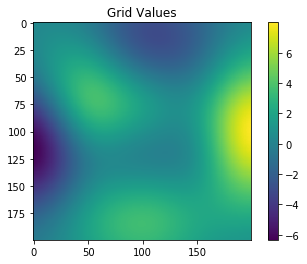

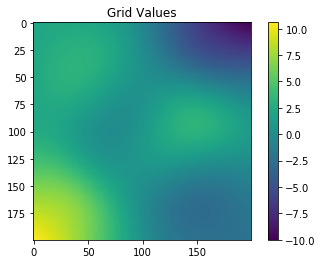

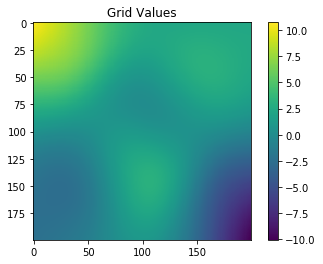

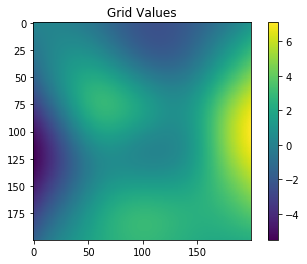

 error =  0.07972586500997335
Done comparing numerical parameters


In [42]:
I_values = [200]#[40, 60, 80, 100, 120, 140, 160, 180, 200]
dt_values = [0.0005]#[0.1, 0.08, 0.06, 0.04,0.02, 0.009, 0.005, 0.0005]

N = len(I_values)
K = len(dt_values)

error = np.zeros((N,K), dtype=np.float64)

for n in range(N):
    I = I_values[n]
    J = I
        
    min_coord = vec2(-1.5, -1.5)
    max_coord = vec2(1.5, 1.5)
        
    for k in range(K):
        grid = SimpleGrid2D(min_coord, max_coord, I, J)
        grid.eval_func( peaks )
        dT = dt_values[k]
        T = 2.0*np.pi
        print("Running on grid (I,J) = (", I, J, "), total time = ", T, " and timestep dt = ", dT)
        merit_0 = np.sum(np.abs( grid.values.flatten() ))*grid.dx*grid.dy

        xt = np.stack([grid.X, grid.Y], axis=2)
        u = np.stack([grid.Y, -grid.X], axis=2)
        show_grid(grid)
        while T>0:
            dt = np.min([dT, T])

            x_prev = xt - dt*u
            val = grid.interpolate_array(x_prev)
            grid.values = val
            
            if(T < 0.75*np.pi + dt/2 and T > 0.75*np.pi - dt/2):
                show_grid(grid)
            if(T < 1.25*np.pi + dt/2 and T > 1.25*np.pi - dt/2):
                show_grid(grid)

            T = T - dt
        show_grid(grid)
        merit_T = np.sum(np.abs( grid.values.flatten() ))*grid.dx*grid.dy
        error[n,k] = np.abs(merit_T - merit_0) / np.abs(merit_0)
        print(" error = ", error[n,k])
print("Done comparing numerical parameters")

In [58]:
I_values = [40]#[40, 60, 80, 100, 120, 140, 160, 180, 200]
dt_values = [0.0001, 0.00001]#[0.1, 0.08, 0.06, 0.04,0.02, 0.009, 0.005, 0.0005]

N = len(I_values)
K = len(dt_values)

error = np.zeros((N,K), dtype=np.float64)

for n in range(N):
    I = I_values[n]
    J = I
        
    min_coord = vec2(-5, -5)
    max_coord = vec2(5, 5)
        
    for k in range(K):
        grid = SimpleGrid2D(min_coord, max_coord, I, J)
        grid.eval_func( peaks )
        dT = dt_values[k]
        T = 2.0*np.pi
        print("Running on grid (I,J) = (", I, J, "), total time = ", T, " and timestep dt = ", dT)
        merit_0 = np.sum(np.abs( grid.values.flatten() ))*grid.dx*grid.dy

        xt = np.stack([grid.X, grid.Y], axis=2)
        u = np.stack([grid.Y, -grid.X], axis=2)
        #cooler_show_grid(grid,clamp=False)
        while T>0:
            dt = np.min([dT, T])

            x_prev = xt - dt*u
            val = grid.interpolate_array(x_prev)
            grid.values = val
            
            # if(T < 0.75*np.pi + dt/2 and T > 0.75*np.pi - dt/2):
            #     cooler_show_grid(grid,clamp=False)
            # if(T < 1.25*np.pi + dt/2 and T > 1.25*np.pi - dt/2):
            #     cooler_show_grid(grid,clamp=False)

            T = T - dt
        #cooler_show_grid(grid,clamp=False)
        merit_T = np.sum(np.abs( grid.values.flatten() ))*grid.dx*grid.dy
        error[n,k] = np.abs(merit_T - merit_0) / np.abs(merit_0)
        print(" error = ", error[n,k])
print("Done comparing numerical parameters")

Running on grid (I,J) = ( 40 40 ), total time =  6.283185307179586  and timestep dt =  0.0001
 error =  0.4458898787986784
Running on grid (I,J) = ( 40 40 ), total time =  6.283185307179586  and timestep dt =  1e-05
 error =  0.4457297445400349
Done comparing numerical parameters


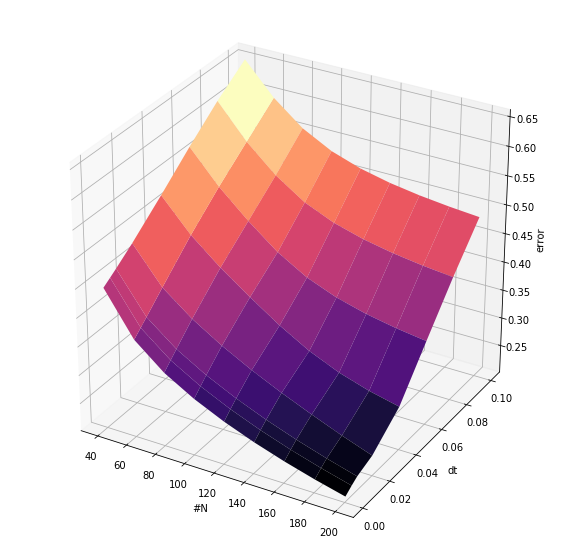

In [159]:
DT, DI = np.meshgrid(dt_values, I_values)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(DI, DT, error, cmap="magma", color='0.75', rstride=1, cstride=1)
ax.set_xlabel("#N")
ax.set_ylabel("dt")
ax.set_zlabel("error")
plt.show()


# Signed Distance Fields
Before we can start on the mean curvature assignment we are in need of a function that can compute a signed distance field.

The next function takes a query point q as input and a closed polygon, poly, and computes the signed distance between q and poly. If the value is positive the q is outside the polygon if the value is negative then q is inside the polygon. The polygon is represented its N-corners and these are stored in an (N+1)-by-2 numpy array. First column is x-coordinates and second column is y-coordinates. The first and last row should be the same corner inorder to close the polygon.

This function is convenient when evaluating a signed distance field on a grid.

In [8]:
def compute_signed_distance(poly, q):
    
    def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

    N = poly.shape[0]
    d = np.inf

    # Compute distance to closest surface point
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        
        ba = b - a     # Vector from a to b
        bal = np.linalg.norm(ba) # Length of ba vector
        if bal == 0:
            continue
        ban = ba / bal # Normal of the vector from a to b
        qa = q - a     # The vector from the query point to a
        alpha = np.dot(qa, ban) / bal
        if alpha < 0:
            da = np.linalg.norm(q-a)
            if da < d:
                d = da
        elif alpha > 1:
            db = np.linalg.norm(q-b)
            if db < d:
                d = db
        else:
            banp = np.array([-ban[1], ban[0]])
            dp = abs(np.dot(qa, banp))
            if dp < d:
                d = dp
    # Compute winding number to set the sign
    wn = 0
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        if a[1] <= q[1]:
            if b[1] > q[1]:
                if is_left(a, b, q) > 0:
                    wn = wn + 1
        else:
            if b[1] <= q[1]:
                if is_left(a, b, q) < 0:
                    wn = wn -1
    if wn < -0.5:
        d = -d
    elif wn > 0.5:
        d = -d
    return d

# Mean Curvature Flow
The central part of the mean curvature flow assignment is to be able to evaluate the value of the mean curvature by using higher order finite difference approximations and dealing properly with boundary conditions and any numerical remedies that would be needed for stability.

We have created a single function that takes a grid as input assuming this grid is holding a signed distance field and then the function computes the mean curvature field of the signed distance field.

Your task is to write the function based on the lecture 12 slides.

In [9]:
def compute_mean_curvature(grid):
    # MEAN_CURVATURE_FLOW - Mean Curvature Flow
    # INPUT:
    #      grid - initial signed distance map
    # RESULT:
    #      kappa - the mean curvature field of the signed distance field

    #
    #   TODO Write your code here!
    #
    kappa = np.zeros((grid.I,grid.J))
    cpy = make_copy(grid)
    #cpy.values = np.pad(cpy.values,1,mode='constant', constant_values=0)
    cpy.values = np.pad(cpy.values,1,mode='symmetric')
    cooler_show_grid(cpy,clamp=False)
    for i in range(1,cpy.I+1):
        for j in range(1,cpy.J+1):

            Dx = (cpy.values[i+1,j] - cpy.values[i-1,j]) / (2 * cpy.dx)
            Dy = (cpy.values[i,j+1] - cpy.values[i,j-1]) / (2 * cpy.dy)
            Dxx = (cpy.values[i+1,j] - 2*cpy.values[i,j] + cpy.values[i-1,j]) / cpy.dx**2
            Dyy = (cpy.values[i,j+1] - 2*cpy.values[i,j] + cpy.values[i,j-1]) / cpy.dy**2
            Dxy = (cpy.values[i+1,j+1] - cpy.values[i+1,j-1] - cpy.values[i-1,j+1] + cpy.values[i-1,j-1]) / (4 * cpy.dx * cpy.dy)

            g = np.sqrt(Dx**2 + Dy**2)
            if(g < 0.5):
                g = 1

            k = (Dx**2 * Dyy + Dy**2 * Dxx - 2*Dxy * Dx * Dy) / g**3
            k_max = 1 / max(cpy.dx, cpy.dy)
            k = max(-k_max, min(k,k_max))
            kappa[i-1,j-1] = k
    return kappa

In [12]:
grid = define_grid()
kappa = np.zeros((grid.I,grid.J))
cpy = make_copy(grid)
#cpy.values = np.pad(cpy.values,1,mode='constant', constant_values=0)
cpy.values = np.pad(cpy.values,1,mode='symmetric')
cooler_show_grid(cpy,clamp=False)

In [10]:
def compute_mean_curvature_constant(grid,constant):
    # MEAN_CURVATURE_FLOW - Mean Curvature Flow
    # INPUT:
    #      grid - initial signed distance map
    # RESULT:
    #      kappa - the mean curvature field of the signed distance field

    #
    #   TODO Write your code here!
    #
    kappa = np.zeros((grid.I,grid.J))
    cpy = make_copy(grid)
    #cpy.values = np.pad(cpy.values,1,mode='constant', constant_values=0)
    cpy.values = np.pad(cpy.values,(1,1),mode='constant', constant_values=constant)
    for i in range(1,cpy.I+1):
        for j in range(1,cpy.J+1):

            Dx = (cpy.values[i+1,j] - cpy.values[i-1,j]) / (2 * cpy.dx)
            Dy = (cpy.values[i,j+1] - cpy.values[i,j-1]) / (2 * cpy.dy)
            Dxx = (cpy.values[i+1,j] - 2*cpy.values[i,j] + cpy.values[i-1,j]) / cpy.dx**2
            Dyy = (cpy.values[i,j+1] - 2*cpy.values[i,j] + cpy.values[i,j-1]) / cpy.dy**2
            Dxy = (cpy.values[i+1,j+1] - cpy.values[i+1,j-1] - cpy.values[i-1,j+1] + cpy.values[i-1,j-1]) / (4 * cpy.dx * cpy.dy)

            g = np.sqrt(Dx**2 + Dy**2)
            if(g < 0.5):
                g = 1

            k = (Dx**2 * Dyy + Dy**2 * Dxx - 2*Dxy * Dx * Dy) / g**3
            k_max = 1 / max(cpy.dx, cpy.dy)
            k = max(-k_max, min(k,k_max))
            kappa[i-1,j-1] = k
    return kappa

In [29]:
def compute_mean_curvature_natural(grid):
    # MEAN_CURVATURE_FLOW - Mean Curvature Flow
    # INPUT:
    #      grid - initial signed distance map
    # RESULT:
    #      kappa - the mean curvature field of the signed distance field

    #
    #   TODO Write your code here!
    #
    kappa = np.zeros((grid.I,grid.J))
    cpy = make_copy(grid)
    cpy.values = np.pad(cpy.values,1,mode='constant', constant_values=0)
    cpy.values[0,:] = 2*cpy.values[1,:] - cpy.values[2,:]
    cpy.values[-1,:] = 2*cpy.values[-2,:] - cpy.values[-3,:]
    cpy.values[:,0] = 2*cpy.values[:,1] - cpy.values[:,2]
    cpy.values[:,-1] = 2*cpy.values[:,-2] - cpy.values[:,-3]

    cpy.values[0,0] = cpy.values[0,1] + cpy.values[1,0] - cpy.values[1,1]
    cpy.values[-1,0] = cpy.values[-2,0] + cpy.values[-1,1] - cpy.values[-2,1]
    cpy.values[0,-1] = cpy.values[0,-2] + cpy.values[1,-1] - cpy.values[1,-2]
    cpy.values[-1,-1] = cpy.values[-2,-1] + cpy.values[-1,-2] - cpy.values[-2,-2]
    cooler_show_grid(cpy,clamp=False)
    for i in range(1,cpy.I+1):
        for j in range(1,cpy.J+1):

            Dx = (cpy.values[i+1,j] - cpy.values[i-1,j]) / (2 * cpy.dx)
            Dy = (cpy.values[i,j+1] - cpy.values[i,j-1]) / (2 * cpy.dy)
            Dxx = (cpy.values[i+1,j] - 2*cpy.values[i,j] + cpy.values[i-1,j]) / cpy.dx**2
            Dyy = (cpy.values[i,j+1] - 2*cpy.values[i,j] + cpy.values[i,j-1]) / cpy.dy**2
            Dxy = (cpy.values[i+1,j+1] - cpy.values[i+1,j-1] - cpy.values[i-1,j+1] + cpy.values[i-1,j-1]) / (4 * cpy.dx * cpy.dy)

            g = np.sqrt(Dx**2 + Dy**2)
            if(g < 0.5):
                g = 1

            k = (Dx**2 * Dyy + Dy**2 * Dxx - 2*Dxy * Dx * Dy) / g**3
            k_max = 1 / max(cpy.dx, cpy.dy)
            k = max(-k_max, min(k,k_max))
            kappa[i-1,j-1] = k
    return kappa

In [14]:
grid = define_grid()
kappa = np.zeros((grid.I,grid.J))
cpy = make_copy(grid)
cpy.values = np.pad(cpy.values,1,mode='constant', constant_values=0)
cpy.values[0,:] = 2*cpy.values[1,:] - cpy.values[2,:]
cpy.values[-1,:] = 2*cpy.values[-2,:] - cpy.values[-3,:]
cpy.values[:,0] = 2*cpy.values[:,1] - cpy.values[:,2]
cpy.values[:,-1] = 2*cpy.values[:,-2] - cpy.values[:,-3]

cpy.values[0,0] = 2*cpy.values[0,1] + 2*cpy.values[1,0] - 3*cpy.values[1,1]
cpy.values[-1,0] = 2*cpy.values[-2,0] + 2*cpy.values[-1,1] - 3*cpy.values[-2,1]
cpy.values[0,-1] = 2*cpy.values[0,-2] + 2*cpy.values[1,-1] - 3*cpy.values[1,-2]
cpy.values[-1,-1] = 2*cpy.values[-2,-1] + 2*cpy.values[-1,-2] - 3*cpy.values[-2,-2]
cooler_show_grid(cpy,clamp=False)

To test our curvature field we must first create a grid instance that holds a signed distance field

In [11]:
def define_grid():    
    poly = np.zeros((5,2),dtype=np.float64)
    poly[0,:] = vec2(-1,-1)
    poly[1,:] = vec2( 1,-1)
    poly[2,:] = vec2( 1, 1)
    poly[3,:] = vec2(-1, 1)
    poly[4,:] = vec2(-1,-1)
            
    min_coord = vec2(-2, -2)
    max_coord = vec2(2, 2)
            
    grid = SimpleGrid2D(min_coord, max_coord, 64, 64)
    grid.eval_func( lambda p: compute_signed_distance(poly,p) )

    return grid

In [40]:
grid = define_grid()
cooler_show_grid(grid,clamp=False)

In order to plot, let's save the curvature field we start with in another variable. We'll call it original. 

In [14]:
grid = define_grid()
original = make_copy(grid)

All pieces are now in place to setup the mean curvature flow main loop. This loop evolves the distance field using the mean curvature field as the speed function. Once we are done we plot contours of the original and the resulting distance fields to see the effect on the shape. 

In [42]:
grid = define_grid()

T = 0.5
dt = 0.001
while T>0:
    kappa = compute_mean_curvature(grid)
    grid.values = grid.values + dt*kappa
    #show_grid(grid)
    T = T - dt

cooler_show_grid(grid,clamp=False)  
show_grid(grid)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Mean Curvature Field from Last Iteration, symmetric')
plt.imshow(kappa)
plt.colorbar(orientation='vertical')
ax.set_aspect('equal')
ax.set_xlabel('i')
ax.set_ylabel('j')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.contour(original.X, original.Y, original.values, [0.0], colors='r')
plt.contour(grid.X, grid.Y, grid.values, [0.0], colors='b')
ax.set_title('Countour comparison')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

/Users/Shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: 

In [74]:
grid.values[29,34]

0.00426924417479343

In [41]:
grid = define_grid()

T = 0.5
dt = 0.001
while T>0:
    kappa = compute_mean_curvature_constant(grid,0)
    grid.values = grid.values + dt*kappa
    #show_grid(grid)
    T = T - dt

cooler_show_grid(grid,clamp=False)
show_grid(grid)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Mean Curvature Field from Last Iteration, constant 0')
plt.imshow(kappa)
plt.colorbar(orientation='vertical')
ax.set_aspect('equal')
ax.set_xlabel('i')
ax.set_ylabel('j')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.contour(original.X, original.Y, original.values, [0.0], colors='r')
plt.contour(grid.X, grid.Y, grid.values, [0.0], colors='b')
ax.set_title('Countour comparison')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

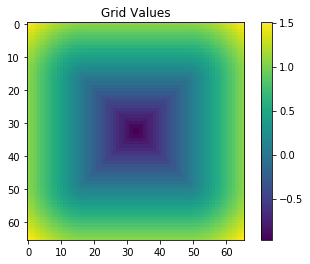

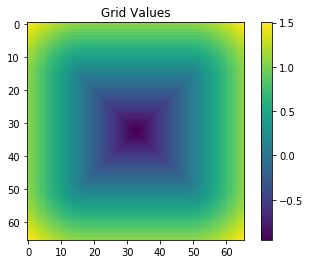

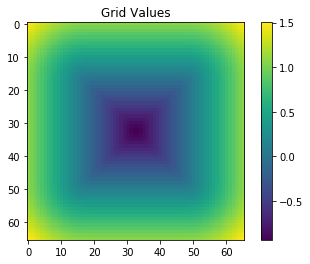

KeyboardInterrupt: 

In [28]:
grid = define_grid()

T = 0.5
dt = 0.001
while T>0:
    kappa = compute_mean_curvature_natural(grid)
    grid.values = grid.values + dt*kappa
    T = T - dt

cooler_show_grid(grid,clamp=False)
show_grid(grid)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Mean Curvature Field from Last Iteration, constant 4')
plt.imshow(kappa)
plt.colorbar(orientation='vertical')
ax.set_aspect('equal')
ax.set_xlabel('i')
ax.set_ylabel('j')

fig = plt.figure()
ax = fig.add_subplot(111)
plt.contour(original.X, original.Y, original.values, [0.0], colors='r')
plt.contour(grid.X, grid.Y, grid.values, [0.0], colors='b')
ax.set_title('Countour comparison')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()